## EWAS_Aging_Run_full_XGboost_Boostrap_Analysis_on_breast
DC

#### This notebook contains code to:
* Specify a tissue of interst from the EWAS Aging dataset.
* load the EWAS aging text data file (age_methylation_v1.txt)
* rewrite it to a new csv file with just the samples from the tissue of interest.
* read back into a dataframe in chunks the written file and combined the chunks into a new dataframe.
* transpose the dataframe so cpgs are the columns
* add back columns for age and tissue
* drop all cpgs columns with more than 75% NAs
* fill remaining NAs with the mean for each column
* write dataframe to a file.
* select only samples with age over 20.
* split data 75/25, working / heldout 
* Run XGboost 50 time on working data (can take many hours)
* Select top100 cpgs 
* fit models using just the top 100 cpgs, linear rg, XGboost, ridge_lg, lasso_lg
* Test model on the Held Out data, linear rg, XGboost, ridge_lg, lasso_lg


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
plt.rcdefaults()

In [2]:
import csv
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

In [17]:
import os
# Get
os.getcwd()
# Change
os.chdir('/Users/dcox/EWAS age premade')
os.getcwd()

'/Users/dcox/EWAS age premade'

## Must Set Tissue of Interest

In [4]:
tissue_of_interest = 'breast'

## Load other models of cpg lists (optional)

In [6]:
# import pickle

# with open('cpgs_XGboost_brain_ranked', 'rb') as fp:
#     cpgs_XGboost_brain_ranked = pickle.load(fp)

# with open('cpgs_XGboost_whole_blood_ranked', 'rb') as fp:
#     cpgs_XGboost_brain_ranked = pickle.load(fp)

    
# with open('mod_lg_best_dropNA_XGboost50', 'rb') as fp:
#     mod_lg_best_dropNA_XGboost50 = pickle.load(fp)         

          
# with open('Top100cpgs_dropNA_XGboost50', 'rb') as fp:
#     Top100cpgs_dropNA_XGboost50 = pickle.load(fp)
       
# with open('Top42_common_dropNA_corr1000_XGboost50', 'rb') as fp:
#     Top42_common_dropNA_corr1000_XGboost50 = pickle.load(fp) 

# with open('mod_lg_best_dropNA_42common', 'rb') as fp:
#     mod_lg_best_dropNA_42common = pickle.load(fp)

## Functions for Modeling

In [7]:
def test_model_on_heldout_data(X_saved, y_saved, model, mtype='Linear Regression', figsize=(8,4), xlim=None):
    
    # Using  model to make predictions on saved data
    preds_on_saved = model.predict(X_saved)
    MSE_test = mean_squared_error(y_saved, preds_on_saved)
    rms_test = (mean_squared_error(y_saved, preds_on_saved))**0.5
    r2_test = r2_score(y_saved, preds_on_saved)
    MAE_test = mean_absolute_error(y_saved, preds_on_saved)
    r_test_corr = np.corrcoef(y_saved, preds_on_saved)[0,1] # preds_on_saved
    
    # Plotting results
    model_type = mtype

    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.scatter(y_saved, preds_on_saved, alpha=0.5)
    ax.plot(range(20,100), range(20,100), c='red')
    ax.set_xlabel('True Age')
    if xlim !=None:
        ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel('Predicted Age')
    ax.grid(True, lw=1.5, ls='--', alpha=0.75)
    ax.set_title(f'{model_type} on Held Out data')
    plt.show()

    # print metric
    print(f'The MSE on the saved data is {MSE_test:.3f} years')
    print(f'The rms on the saved data is {rms_test:.3f} years')
    print(f'The r^2 on the saved data is {r2_test:.3f}')
    print(f'The mae on the saved data is {MAE_test:.3f} years')
    print(f'The correlation on the held out data true-predicted is {r_test_corr:.3f}')
    
    return preds_on_saved, MSE_test, rms_test, r2_test, MAE_test, r_test_corr

In [8]:
# Run Linear Regression model and plot and print results
from sklearn.linear_model import LinearRegression
def linear_regress(X_train, y_train, X_test, y_test, plot=True):
    
    #Build fit model
    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Linear Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Linear Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f}')
    
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [9]:
# Function for running XGboost regression and print results
from xgboost import XGBRegressor
def xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True):
    
    #Build fit model
    XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
    eval_set = [(X_train, y_train),(X_test, y_test)]
    XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
    
    
    # Make predictions and evaluate
    preds_train = XG.predict(X_train)
    preds_test = XG.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    results = XG.evals_result()
    epochs = len(results['validation_0']['rmse'])
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(16,3.5))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('XGboost on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('XGboost on testing data')

        x_axis = range(0, epochs)
        ax[2].plot(x_axis, results['validation_0']['rmse'], label='Train')
        ax[2].plot(x_axis, results['validation_1']['rmse'], label='Test')
        ax[2].legend()
        ax[2].set_ylabel('rms')
        ax[2].set_xlabel('epoch')
        ax[2].set_title('XGBoost rms')
        plt.show()
    
    # print metric
    print(f'The number of training epochs was {epochs}')
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    
    
    return XG, rms_train, rms_test, r2_train, r2_test, XG.feature_importances_

In [10]:
# Function for running a ridge Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import RidgeCV
def ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = RidgeCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Ridge Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Ridge Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    print(f'Optimal alpha from CV = {mod.alpha_}')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [11]:
# Function for running a lasso Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import LassoCV
def lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = LassoCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Lasso Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Lasso Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    print(f'Optimal alpha from CV = {mod.alpha_}')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [12]:
# repeat_XGBoost numtrials times using a different split each time 
# returns importance scores for each run in a df 
def repeat_XGBoost(df_processed, numtrials, early_stopping_rounds = 10, test_size=0.20):
    X = df_processed.iloc[:,5:]
    y = df_processed.age
    importances = []
    rms_train = []
    rms_test = []
    r2_train = []
    r2_test = []
    for i in range(numtrials): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
        eval_set = [(X_train, y_train),(X_test, y_test)]
        XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
        
        preds_train = XG.predict(X_train)
        preds_test = XG.predict(X_test)
        rms_train.append((mean_squared_error(y_train, preds_train))**0.5)
        rms_test.append((mean_squared_error(y_test, preds_test))**0.5)
        r2_train.append(r2_score(y_train, preds_train))
        r2_test.append(r2_score(y_test, preds_test))
        print(i+1, f'r^2 test = {r2_score(y_test, preds_test)}')
        importances.append(XG.feature_importances_)
    df_imp = pd.DataFrame(importances, columns = df_processed.columns[5:])
    df_imp = df_imp.transpose()
    cols = []
    for i in range(1,numtrials+1):
        cols.append('trial_'+str(i))
    df_imp.columns = cols
    df_imp['Mean'] = df_imp.mean(axis=1)
    df_imp['Std'] = df_imp.std(axis=1)
    return df_imp, rms_train, rms_test, r2_train, r2_test

# Takes df of importance scores produced by repeat_XGBoost and sorts by mean imp score
def importances_sorted_by_mean(df_imp):
    df_imp_sorted = df_imp.sort_values('Mean', ascending=False)
    return df_imp_sorted

# Makes a histogram of the frequecy of cgs in the top (top_num) importance scores
def histogram_of_top_CpGs_by_importance(df_imp, top_num=20):
    vs = []
    inds = []
    for col in df_imp.columns[:-2]:
        c = df_imp[col].sort_values(ascending=False)
        vs.append(c[:top_num])
        inds  = inds + list(c.index[:top_num])
    h = pd.Series(inds).value_counts()
    # Plotting the first 100 importance scores
    plt.figure(figsize = (30, 12))
    plt.bar(h.index[:100],h[:100])
    plt.title('Frequency of CpGs in the top 100 importances')
    plt.ylabel('Frequency')
    plt.xlabel('CpG')
    plt.xticks(fontsize = 16, rotation=90)
    plt.show()
    return inds, vs, h

### Function for loading data file and writing subset file by tissue, uses csv package for speed, not pandas

In [13]:
import math
import csv
import re

def findElements(lst1, lst2):
    '''
    returns a list of those elements in list1 that are at the position indices given in list2
    '''
    return [lst1[i] for i in lst2] 

def read_write_age_data_by_tissue(file_in, file_out, search_term, num_rows='all'):
    '''
    Built to operate on the EWAS aging dataset text file named 'age_methylation_v1.txt'
    
    Takes an input csv file, a file name to write to, and a search term which should equal a type of tissue 
    in the tissue row of the data (3rd row).
    
    Writes to a csv file the input data but containingg only the columns with tissue containing any where in it
    the search term
    
    params: 
        file_in (string) (file.csv) path to some existing csv file to read
        file_out (string) name of csv file to write 
        search_term (string) term to search for in tissue row
        
    returns:
        None
    '''
    with open(file_in, 'r') as file_in:

        csv_in = csv.reader(file_in,delimiter= '\t')

        header = next(csv_in)
        age = next(csv_in)
        tissue = next(csv_in)
       
        indices = [0]
        for i, element in enumerate(tissue):
            if re.search(search_term, element):
                indices.append(i)
            
        if len(indices) == 0:
            print('Tissue not found')
            return None 
        
        with open(file_out, 'w') as f_out:
            line_list = []
            csv_out = csv.writer(f_out)

            new_header =  findElements(header, indices)
            new_age =  findElements(age, indices)
            new_tissue =  findElements(tissue, indices)

            csv_out.writerow(new_header)
            #csv_out.writerow(new_age)
            #csv_out.writerow(new_tissue)

            count = 0
            if num_rows=='all':
                for line in csv_in:
                    save = findElements(line, indices)
                    csv_out.writerow(save)
                    count +=1
                    if count%10000 == 0:
                        print(f'finished line {count}')
            else:
                for line in csv_in:
                    if count >= num_rows:
                        break
                    else:
                        save = findElements(line, indices)
                        csv_out.writerow(save)
                        count +=1
                        if count%10000 == 0:
                            print(f'finished line {count}')
        return new_header, new_age, new_tissue

        print(f'\n{count} lines sent to file {file_out} with the tissue field containing {search_term}')

## Loading Data to dataframe

### Read data file and write new file with data from the selected tissue

In [14]:
'./age_methylation_v1/'+ tissue_of_interest + '_age_methylation_v1.txt'

'./age_methylation_v1/breast_age_methylation_v1.txt'

In [18]:
%%time
# Writing data to a file with the above function selecting out a certain tissue
file_out = './age_methylation_v1/'+ tissue_of_interest + '_age_methylation_v1.txt'
new_header, new_age, new_tissue = read_write_age_data_by_tissue('./age_methylation_v1/age_methylation_v1.txt', file_out, tissue_of_interest, num_rows='all')

finished line 10000
finished line 20000
finished line 30000
finished line 40000
finished line 50000
finished line 60000
finished line 70000
finished line 80000
finished line 90000
finished line 100000
finished line 110000
finished line 120000
finished line 130000
finished line 140000
finished line 150000
finished line 160000
finished line 170000
finished line 180000
finished line 190000
finished line 200000
finished line 210000
finished line 220000
finished line 230000
finished line 240000
finished line 250000
finished line 260000
finished line 270000
finished line 280000
finished line 290000
finished line 300000
finished line 310000
finished line 320000
finished line 330000
finished line 340000
finished line 350000
finished line 360000
finished line 370000
finished line 380000
finished line 390000
finished line 400000
finished line 410000
finished line 420000
finished line 430000
finished line 440000
finished line 450000
finished line 460000
finished line 470000
finished line 480000
C

### Read back in data in chunks and combine to new dataframe

In [19]:
%%time
# Reading data back in in chunks
import warnings
warnings.simplefilter(action='ignore', category=Warning)

chunksize = 10000
dfs = []
df_chunk = pd.read_csv(file_out, header=0, chunksize=chunksize)
for chunk in df_chunk:
    dfs.append(chunk)

CPU times: user 20 s, sys: 1.47 s, total: 21.5 s
Wall time: 21.9 s


In [20]:
%%time
# Combining chunks into 1 dataframe
df = pd.concat(dfs).set_index('sample_id') 

CPU times: user 1.19 s, sys: 1.13 s, total: 2.33 s
Wall time: 2.35 s


### Transpose dataframe so cpgs are columns, and add columns for age and tissue saved from the write operation

In [21]:
%%time
# transposing dataframe
df_t = df.transpose()

CPU times: user 2.94 ms, sys: 996 µs, total: 3.93 ms
Wall time: 2.72 ms


In [22]:
# Inserting columns for tissue and age and setting age dtype to float and then rounding to int
df_t.insert(0, 'age', new_age[1:])
df_t.insert(0, 'tissue', new_tissue[1:])
df_t.age = df_t.age.astype('float')
df_t.age = df_t.age.apply(np.rint)
df_t.age = df_t.age.astype('int64')

In [23]:
df_t.shape

(535, 485514)

### Dealing with NAs, remove columns with more than 25% NAs, Impute the rest with mean of columns

CPU times: user 905 ms, sys: 211 ms, total: 1.12 s
Wall time: 1.14 s


Text(0, 0.5, 'count')

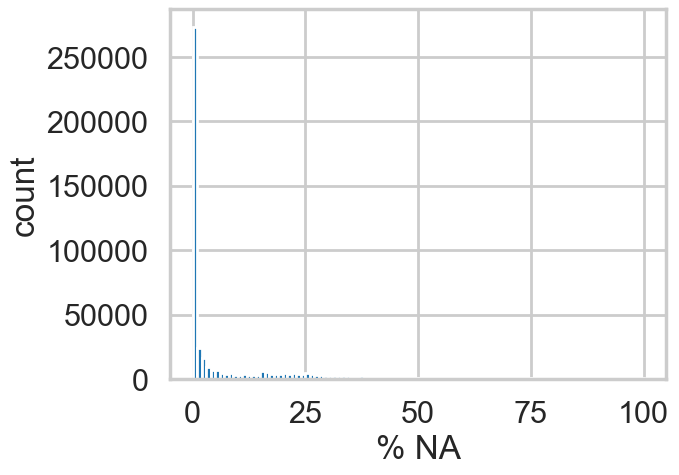

In [24]:
%%time
#looking at a histogram of the percent NAs for the columns
num_nans_hist = 100 * df_t.isna().sum(axis=0)/df_t.shape[0]
num_nans_hist.hist(bins=100)
plt.xlabel('% NA')
plt.ylabel('count')
#plt.ylim(0,50000)

#### Drop all columns with  NAs > 25% of values , then imput with mean of column

In [25]:
# remove columns with more than 25% NAs
df_processed_imp = df_t.dropna(thresh = 0.75*df_t.shape[0], axis=1)

In [26]:
df_processed_imp.shape

(535, 413498)

In [27]:
%%time
# Impute all values with column mean
df_processed_imp = df_processed_imp.fillna(df_processed_imp.mean())

CPU times: user 2min 5s, sys: 14.1 s, total: 2min 19s
Wall time: 2min 27s


In [28]:
%%time
# df_processed_imp.to_csv('df_EWAS_aging_whole_blood_Imputated_with_mean')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


### Selecting out samples with ages over 20 years old

In [29]:
# Selecting out samples with age > 20
df_processed_imp_over20 = df_processed_imp[df_processed_imp.age >=20]

### Histogram of ages in data

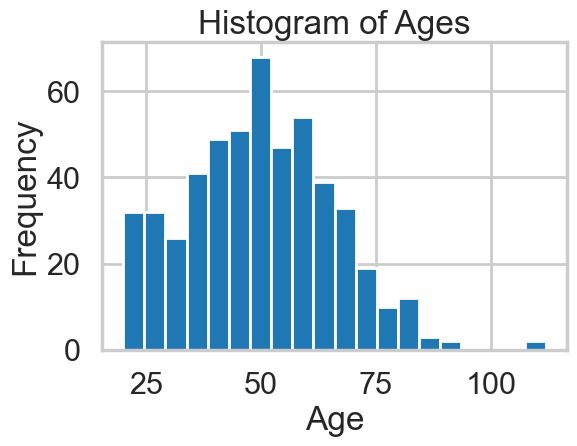

In [30]:
# Histogram of ages in data
plt.figure(figsize = (6,4))
df_processed_imp_over20.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Ages')
plt.show()

### Dividing data into working and saved parts (75/25 split)

In [31]:
df_processed_imp_over20.shape

(520, 413498)

In [32]:
# Splitting data into Working and Saved by random selection of rows

import random

num_samples = df_processed_imp_over20.shape[0]
num_for_saving = int(round(df_processed_imp_over20.shape[0]*.25))

np.random.seed(2021)

saved_index = np.random.choice(np.arange(num_samples), size=num_for_saving, replace=False)
keep_index = []
for num in range(num_samples):
    if num not in saved_index:
        keep_index.append(num)

df_p_saved = df_processed_imp_over20.iloc[saved_index, :]
df_p_working = df_processed_imp_over20.iloc[keep_index, :]

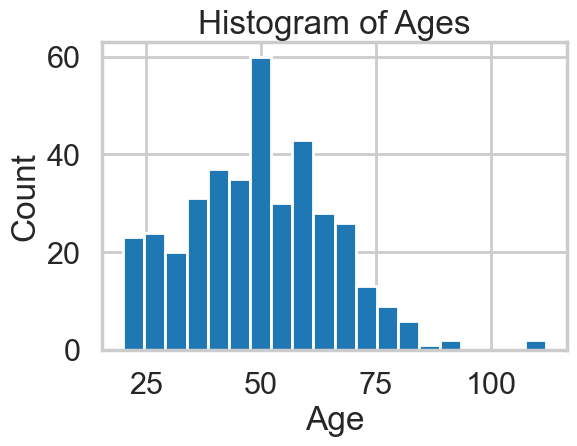

In [33]:
# Histogram of ages in saved data
plt.figure(figsize=(6,4))
df_p_working.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages')
plt.show()

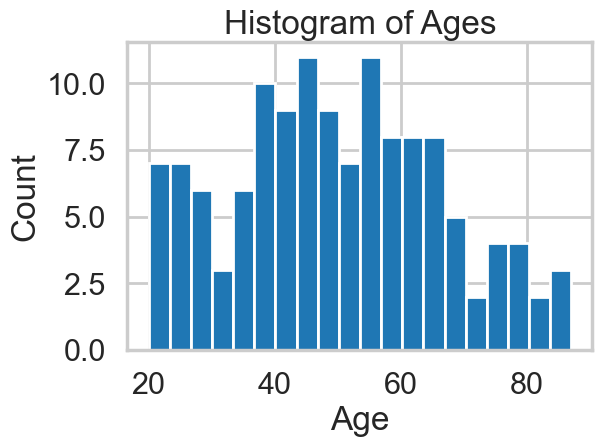

In [34]:
# Histogram of ages in working data
plt.figure(figsize=(6,4))
df_p_saved.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages')
plt.show()

In [35]:
df_p_working

sample_id,tissue,age,cg02494853,cg03706273,cg04023335,cg04964672,cg05213048,cg15295597,cg26520468,cg27539833,cg00008945,cg00011200,cg00011891,cg00014152,cg00016522,cg00016934,cg00018261,cg00021786,cg00026186,cg00072288,cg00072839,cg00074638,cg00112256,cg00114625,cg00114913,cg00116709,cg00139317,cg00140085,cg00142683,cg00192980,cg00200463,cg00206414,cg00240113,cg00241296,cg00241907,cg00243584,cg00264378,cg00265812,cg00266918,cg00360365,cg00373606,cg00374088,cg00378717,cg00378950,cg00380985,cg00381376,cg00388637,cg00391044,cg00399450,cg00408231,...,cg27585287,cg27592453,cg27598806,cg27601574,cg27611781,cg27612019,cg27614432,cg27634071,cg27634744,cg27648216,cg27656573,cg27657363,cg27657537,cg27660038,cg27662611,cg27665648,ch.22.16108507R,ch.22.16454022F,ch.22.40657F,ch.22.78028F,ch.22.17803970R,ch.22.107403R,ch.22.137888R,ch.22.22597277R,ch.22.217069R,ch.22.22928834R,ch.22.23746271F,ch.22.25752197R,ch.22.26167205F,ch.22.317144R,ch.22.26442001R,ch.22.28920330F,ch.22.30020508R,ch.22.427671F,ch.22.467397R,ch.22.31817810F,ch.22.33863861F,ch.22.533187F,ch.22.569473R,ch.22.38010425R,ch.22.694298R,ch.22.707968R,ch.22.740407F,ch.22.757911F,ch.22.43177094F,ch.22.44116734F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R
TCGA-BH-A1FG-11B-12D-A13T-05,breast,88,0.032000,0.026000,0.217,0.700000,0.645,0.029,0.970,0.891,0.332,0.470,0.463,0.931,0.391,0.081,0.435,0.955,0.451,0.378,0.039,0.661,0.552,0.547,0.487,0.514,0.496,0.404,0.496,0.456,0.498,0.208,0.423,0.226,0.365,0.452,0.396,0.502,0.056,0.141,0.418,0.392,0.01300,0.802,0.466,0.009,0.887,0.344,0.470,0.616,...,0.142,0.911000,0.937,0.575,0.071000,0.632,0.024,0.072,0.973000,0.202,0.958,0.933,0.079,0.050,0.039,0.814,0.022000,0.026,0.003000,0.027000,0.135,0.018,0.133,0.034,0.082000,0.113000,0.019000,0.122,0.042,0.050000,0.042,0.150000,0.046000,0.030,0.024,0.012,0.049,0.034,0.126000,0.037,0.063000,0.010,0.026,0.012000,0.019,0.020000,0.012,0.011000,0.059,0.037000
GSM1658467,breast,76,0.011000,0.011000,0.080,0.475000,0.414,0.011,0.982,0.776,0.107,0.430,0.416,0.983,0.341,0.046,0.302,0.975,0.394,0.017,0.067,0.517,0.540,0.255,0.344,0.311,0.257,0.334,0.292,0.311,0.526,0.149,0.493,0.036,0.277,0.493,0.312,0.459,0.053,0.094,0.304,0.274,0.01600,0.589,0.277,0.003,0.583,0.189,0.394,0.350,...,0.189,0.779000,0.853,0.623,0.055367,0.626,0.059,0.014,0.977117,0.286,0.990,0.815,0.185,0.073,0.036,0.905,0.011777,0.002,0.026988,0.020461,0.143,0.004,0.102,0.009,0.070886,0.132267,0.016262,0.035,0.016,0.045662,0.007,0.152846,0.050008,0.014,0.029,0.001,0.044,0.011,0.118000,0.021,0.064479,0.012,0.059,0.021469,0.001,0.022288,0.008,0.000000,0.029,0.006000
GSM2719528,breast,76,0.016000,0.015000,0.180,0.736000,0.800,0.017,0.978,0.806,0.295,0.470,0.543,0.960,0.502,0.053,0.533,0.942,0.495,0.376,0.051,0.658,0.586,0.525,0.436,0.540,0.448,0.429,0.493,0.553,0.450,0.067,0.430,0.157,0.274,0.431,0.430,0.491,0.062,0.132,0.409,0.339,0.02200,0.856,0.475,0.013,0.861,0.336,0.495,0.593,...,0.236,0.819000,0.959,0.568,0.055000,0.664,0.024,0.028,0.980000,0.384,0.945,0.922,0.045,0.067,0.007,0.846,0.005000,0.006,0.014000,0.011000,0.170,0.006,0.146,0.022,0.032000,0.067000,0.011000,0.063,0.009,0.029000,0.011,0.080000,0.028000,0.014,0.010,0.018,0.051,0.016,0.138000,0.023,0.014000,0.003,0.023,0.023000,0.004,0.019000,0.010,0.004000,0.040,0.119000
GSM1658512,breast,81,0.013000,0.009000,0.119,0.576000,0.676,0.013,0.996,0.916,0.373,0.475,0.489,0.967,0.410,0.035,0.479,0.976,0.480,0.385,0.037,0.611,0.465,0.488,0.398,0.502,0.435,0.411,0.477,0.531,0.502,0.128,0.463,0.187,0.264,0.432,0.362,0.512,0.075,0.123,0.357,0.402,0.11400,0.915,0.503,0.005,0.793,0.358,0.526,0.629,...,0.219,0.846496,0.957,0.650,0.048000,0.732,0.017,0.020,0.977117,0.288,0.962,0.956,0.030,0.095,0.324,0.885,0.004000,0.003,0.026988,0.020461,0.150,0.018,0.112,0.099,0.032000,0.081000,0.005000,0.107,0.085,0.045662,0.006,0.077000,0.131000,0.005,0.006,0.004,0.041,0.013,0.107000,0.040,0.064479,0.008,0.018,0.021469,0.014,0.022288,0.014,0.000000,0.060,0.011000
TCGA-BH-A204-11A-53D-A161-05

### Running XGboost 50 times to identify top 100 cpgs

In [36]:
%%time
# Runnin XGboost on working dataset 50 times with 50 different train/test splits
# This can take many hours (on whole blood 10 hrs)
# df_imp, rms_train, rms_test, r2_train, r2_test = repeat_XGBoost(df_p_working, 50, test_size=0.20)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


In [37]:
# df_imp

In [38]:
# write 50 trials results to a file, so don't have to rerun the 50 XGboost trials with the whole dataset again
file = './breast/df_importance_EWAS_age_' + tissue_of_interest + '_50_trials.csv'
#df_imp.to_csv(file)
df_imp = pd.read_csv(file , index_col=0)

In [39]:
# Finding cpgs with on average the highest importance scores, see mean columnn in df below
df_imp_sorted = importances_sorted_by_mean(df_imp)

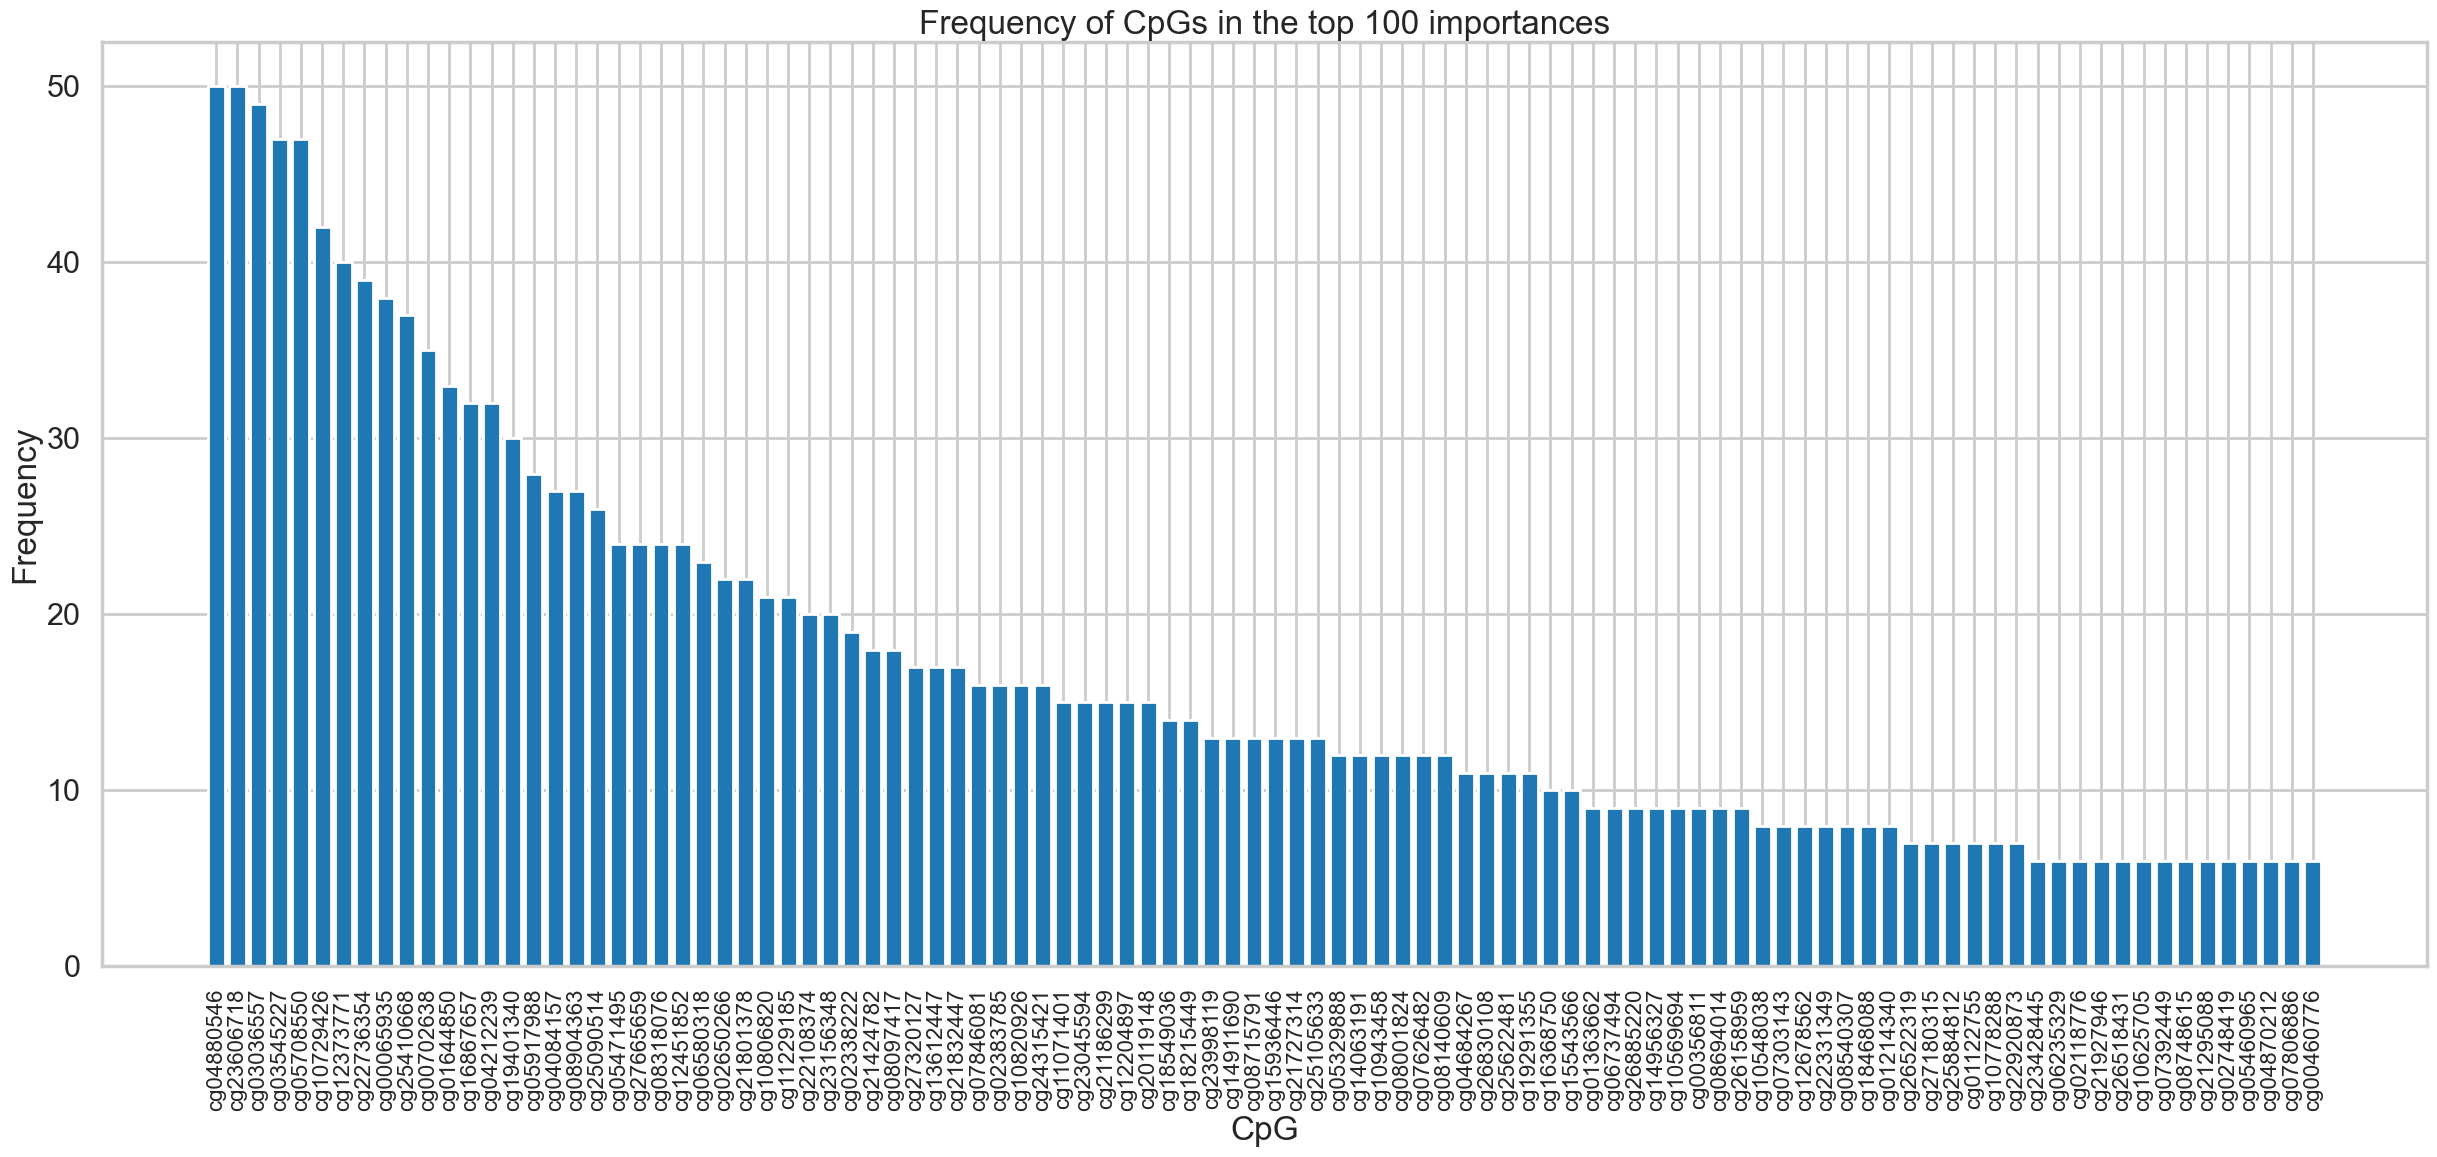

In [40]:
# This function makes a histogram of the frequency of cgs in the top 100 in the 50 trials above
inds, vs, h = histogram_of_top_CpGs_by_importance(df_imp, 100)

In [41]:
cpgs_XGboost_ranked = h.index.values

In [42]:
# Savings Rankings, took 4hrs to get
# import pickle
# file_ranks = 'cpgs_XGboost_'+ tissue_of_interest+ '_ranked'
# with open(file_ranks, 'wb') as fp:
#     pickle.dump(cpgs_XGboost_ranked, fp)

### Modeling with top 100 cpgs

In [43]:
Top100_cpgs_XGboost = h.index[:100].values
plt.rcdefaults()

In [44]:
from sklearn.model_selection import train_test_split
X = df_p_working[Top100_cpgs_XGboost]
y = df_p_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

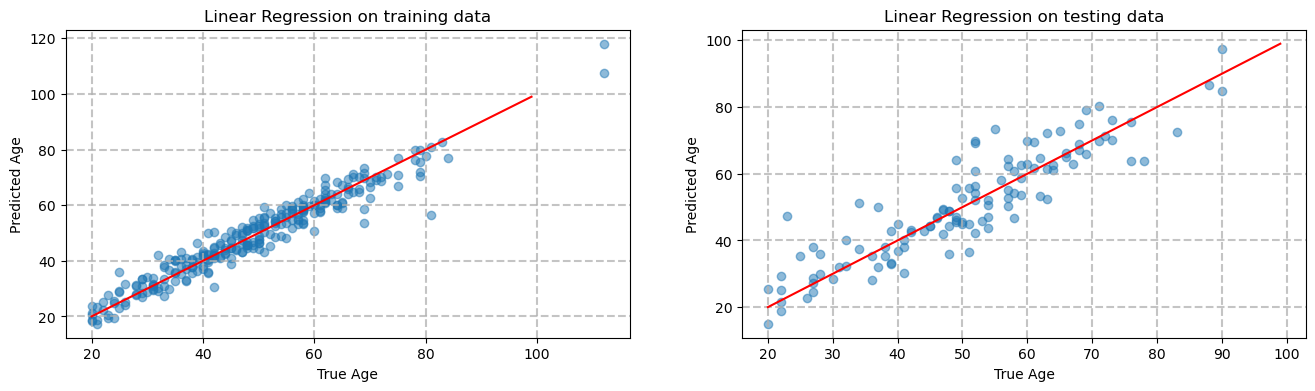

The rms on the training data is 4.020 years
The rms on the testing data is 7.058 years
The r^2 on the training data is 0.935
The r^2 on the testing data is 0.802
The MAe on the training data is 3.026 years
The MAE on the testing data is 5.249


In [45]:
plt.rcdefaults()
mod_100, rms_train, rms_test, r2_train, r2_test = linear_regress(X_train, y_train, X_test, y_test, plot=True)

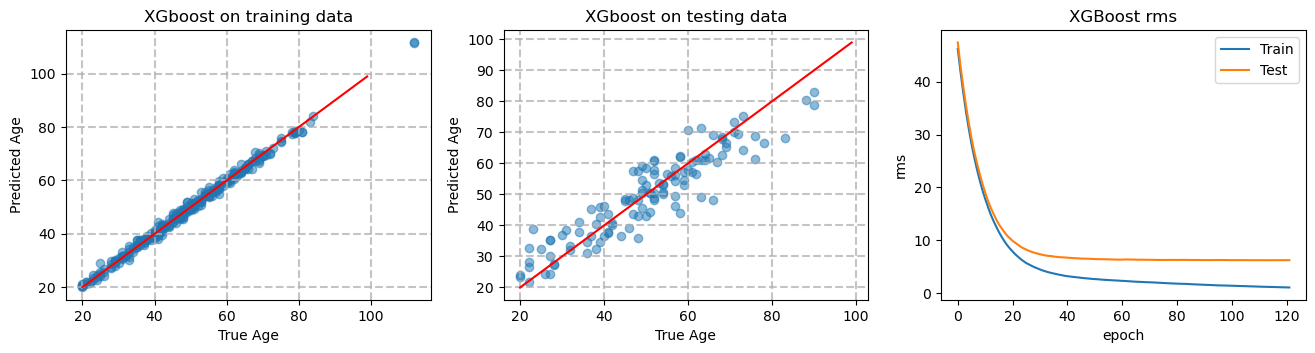

The number of training epochs was 122
The rms on the training data is 1.191 years
The rms on the testing data is 6.218 years
The r^2 on the training data is 0.994
The r^2 on the testing data is 0.846
The MAE on the training data is 0.907 years
The MAE on the testing data is 4.869 years


In [46]:
XG_100, rms_train, rms_test, r2_train, r2_test, feature_importances_ = xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=10, plot=True)

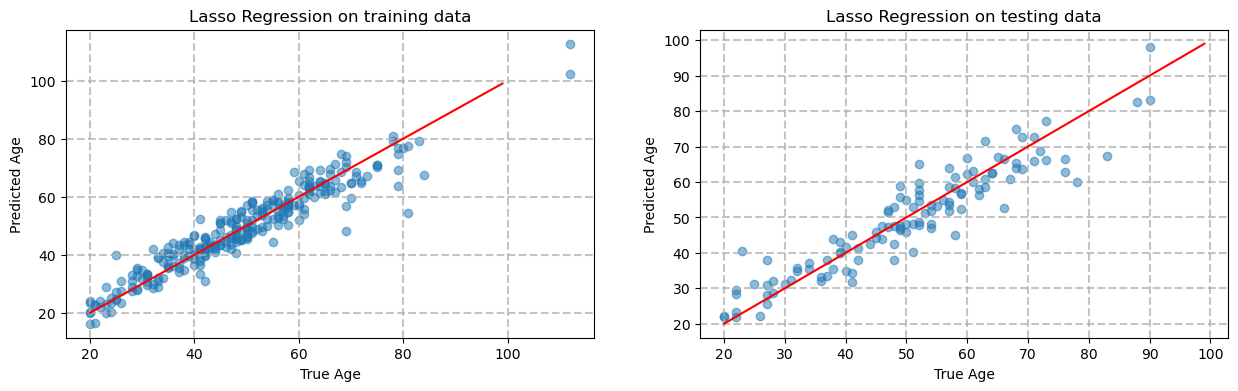

The rms on the training data is 4.818 years
The rms on the testing data is 5.740 years
The r^2 on the training data is 0.907
The r^2 on the testing data is 0.869
The MAE on the training data is 3.556 years
The MAE on the testing data is 4.435 years
Optimal alpha from CV = 0.01


In [47]:
mod_lasso_100, rms_train, rms_test, r2_train, r2_test = lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

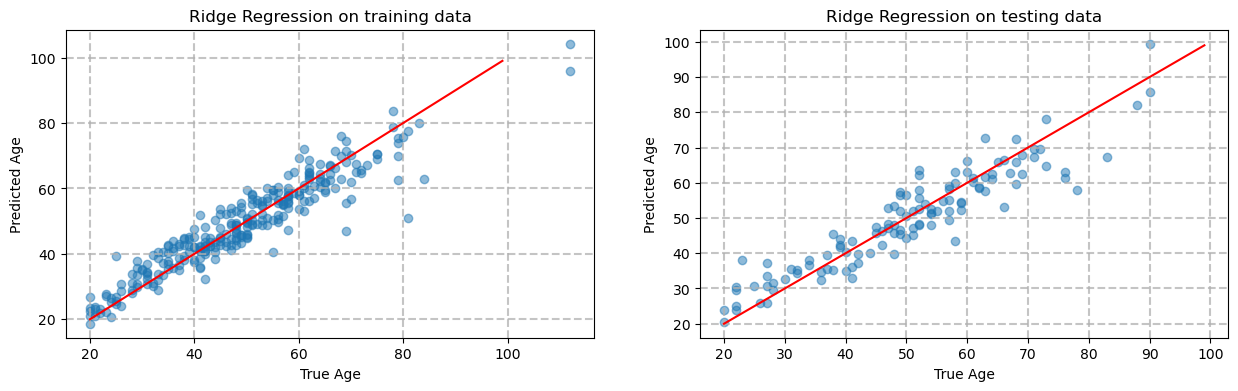

The rms on the training data is 5.360 years
The rms on the testing data is 5.852 years
The r^2 on the training data is 0.884
The r^2 on the testing data is 0.864
The MAE on the training data is 3.903 years
The MAE on the testing data is 4.521 years
Optimal alpha from CV = 1.0


In [48]:
mod_ridge_100, rms_train, rms_test, r2_train, r2_test = ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

In [49]:
# # Save models
# import pickle

# with open('mod_100_breast', 'wb') as fp:
#     pickle.dump(mod_100, fp)
    
# with open('XG_100_breast', 'wb') as fp:
#     pickle.dump(XG_100, fp)
    
# with open('mod_lasso_100_breast', 'wb') as fp:
#     pickle.dump(mod_lasso_100, fp)
    
# with open('mod_ridge_100_breast', 'wb') as fp:
#     pickle.dump(mod_ridge_100, fp)

### Model Perfomance on Heldout Data

In [50]:
X_saved = df_p_saved[Top100_cpgs_XGboost]
y_saved = df_p_saved.age

In [51]:
plt.rcdefaults()

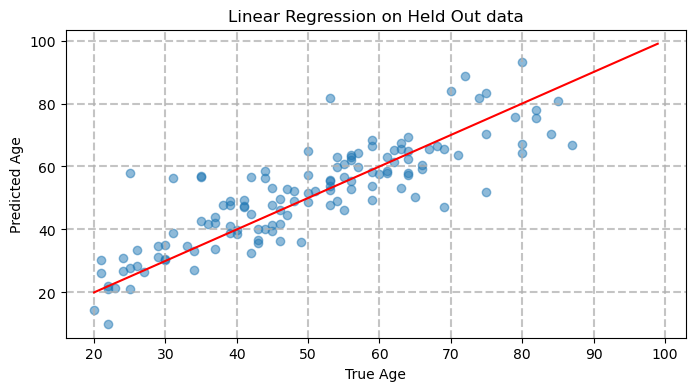

The MSE on the saved data is 81.485 years
The rms on the saved data is 9.027 years
The r^2 on the saved data is 0.702
The mae on the saved data is 6.676 years
The correlation on the held out data true-predicted is 0.850


In [52]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_100, mtype='Linear Regression', figsize=(8,4), xlim=None)

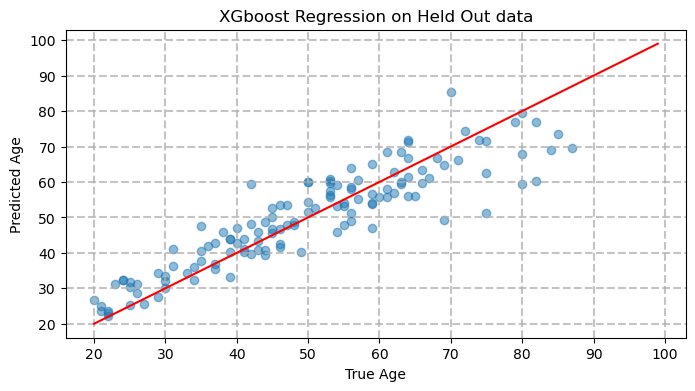

The MSE on the saved data is 49.520 years
The rms on the saved data is 7.037 years
The r^2 on the saved data is 0.819
The mae on the saved data is 5.313 years
The correlation on the held out data true-predicted is 0.907


In [53]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, XG_100, mtype='XGboost Regression', figsize=(8,4), xlim=None)

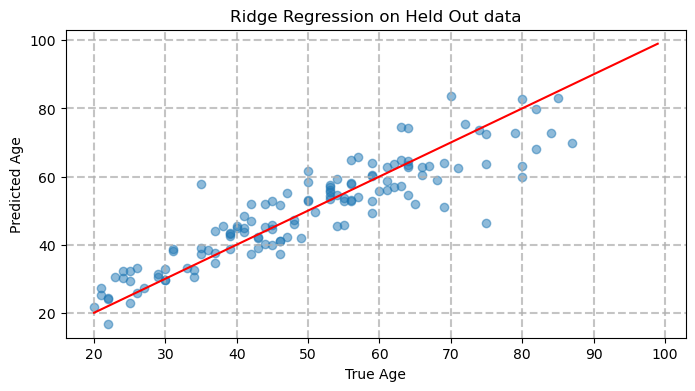

The MSE on the saved data is 49.989 years
The rms on the saved data is 7.070 years
The r^2 on the saved data is 0.817
The mae on the saved data is 5.248 years
The correlation on the held out data true-predicted is 0.905


In [54]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_ridge_100, mtype='Ridge Regression', figsize=(8,4), xlim=None)

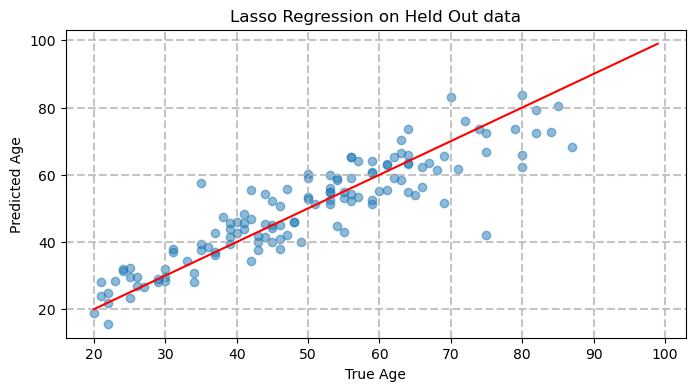

The MSE on the saved data is 50.985 years
The rms on the saved data is 7.140 years
The r^2 on the saved data is 0.814
The mae on the saved data is 5.308 years
The correlation on the held out data true-predicted is 0.902


In [55]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_lasso_100, mtype='Lasso Regression', figsize=(8,4), xlim=None)

The rms on the training data is 4.296 years
The rms on the testing data is 6.936 years
The r^2 on the training data is 0.928
The r^2 on the testing data is 0.797
The MAE on the training data is 3.161 years
The MAE on the testing data is 4.835 years
Optimal alpha from CV = 0.01
The rms on the training data is 4.807 years
The rms on the testing data is 5.838 years
The r^2 on the training data is 0.906
The r^2 on the testing data is 0.868
The MAE on the training data is 3.601 years
The MAE on the testing data is 3.968 years
Optimal alpha from CV = 0.01
The rms on the training data is 4.632 years
The rms on the testing data is 6.056 years
The r^2 on the training data is 0.910
The r^2 on the testing data is 0.866
The MAE on the training data is 3.437 years
The MAE on the testing data is 4.344 years
Optimal alpha from CV = 0.01
The rms on the training data is 4.202 years
The rms on the testing data is 6.694 years
The r^2 on the training data is 0.930
The r^2 on the testing data is 0.814
The 

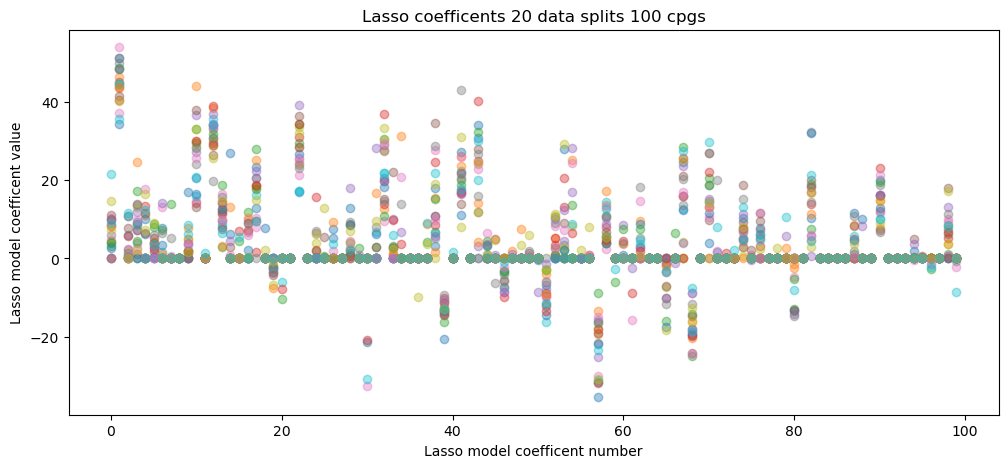

In [56]:
# Looking at Lasso Coefficents 20 data splits to see how split-dependent they are.
plt.figure(figsize = (12, 5))
plt.xlabel('Lasso model coefficent number')
plt.ylabel('Lasso model coefficent value')
plt.title('Lasso coefficents 20 data splits 100 cpgs')
coefs_list = []
for i in range(20):
    X = df_p_working[Top100_cpgs_XGboost]
    y = df_p_working.age
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = i+100)
    model_l, rms_train, rms_test, r2_train, r2_test = lassoCV_regress(X_train, y_train, X_test, y_test, plot=False, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)
    coefs_list.append(model_l.coef_)
    plt.scatter(range(100),model_l.coef_, alpha=0.4 )
plt.show()


In [72]:
# Load old blood model and cpgs
with open('Top100cpgs_dropNA_XGboost50', 'rb') as fp:
    Top100cpgs_dropNA_XGboost50 = pickle.load(fp)

In [73]:
X_saved = df_p_saved[Top100cpgs_dropNA_XGboost50]
y_saved = df_p_saved.age

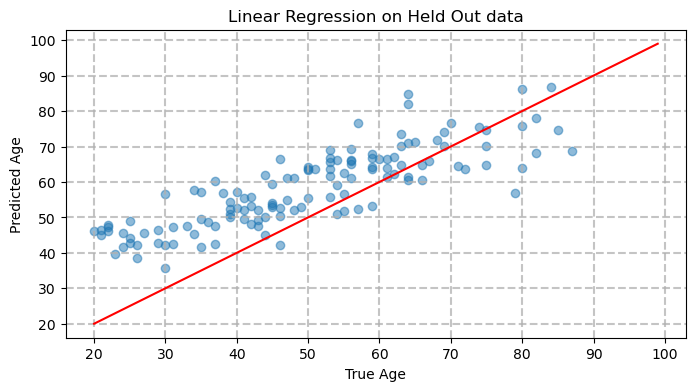

The MSE on the saved data is 163.275 years
The rms on the saved data is 12.778 years
The r^2 on the saved data is 0.403
The mae on the saved data is 10.816 years
The correlation on the held out data true-predicted is 0.833


In [74]:
mod_lg_best_dropNA_XGboost50
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_lg_best_dropNA_XGboost50, mtype='Linear Regression', figsize=(8,4), xlim=None)

In [59]:
import pickle

with open('./models/mod_100_whole_blood', 'rb') as fp:
    mod_100_whole_blood = pickle.load(fp)

with open('./models/XG_100_whole_blood', 'rb') as fp:
    XG_100_whole_blood = pickle.load(fp)
    
with open('./models/mod_lasso_100_whole_blood', 'rb') as fp:
    mod_lasso_100_whole_blood = pickle.load(fp)
    
with open('./models/mod_ridge_100_whole_blood', 'rb') as fp:
    mod_ridge_100_whole_blood = pickle.load(fp)

with open('./models/mod_100_brain', 'rb') as fp:
    mod_100_brain = pickle.load(fp)

with open('./models/XG_100_brain', 'rb') as fp:
    XG_100_brain = pickle.load(fp)
    
with open('./models/mod_lasso_100_brain', 'rb') as fp:
    mod_lasso_100_brain = pickle.load(fp)
    
with open('./models/mod_ridge_100_brain', 'rb') as fp:
    mod_ridge_100_brain = pickle.load(fp)

with open('./cpgs_ranked/cpgs_XGboost_breast_ranked', 'rb') as fp:
    cpgs_XGboost_breast_ranked = pickle.load(fp)
    
with open('./cpgs_ranked/cpgs_XGboost_brain_ranked', 'rb') as fp:
    cpgs_XGboost_brain_ranked = pickle.load(fp)
    
with open('./cpgs_ranked/cpgs_XGboost_whole_blood_ranked', 'rb') as fp:
    cpgs_XGboost_whole_blood_ranked = pickle.load(fp)
       

In [65]:
X_saved = df_p_saved[cpgs_XGboost_whole_blood_ranked[:100]]
y_saved = df_p_saved.age

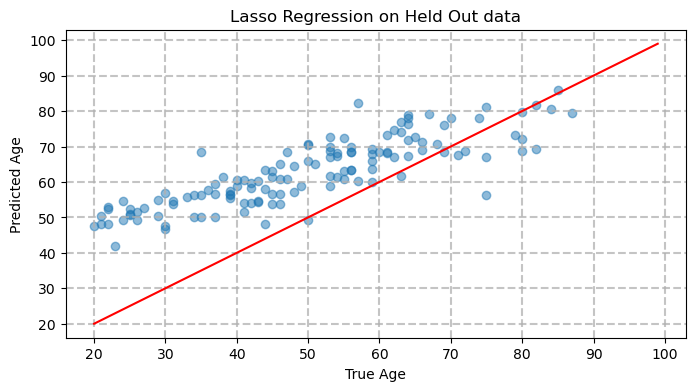

The MSE on the saved data is 263.933 years
The rms on the saved data is 16.246 years
The r^2 on the saved data is 0.035
The mae on the saved data is 14.190 years
The correlation on the held out data true-predicted is 0.844


In [66]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_lasso_100_whole_blood, mtype='Lasso Regression', figsize=(8,4), xlim=None)



In [67]:
X_saved = df_p_saved[cpgs_XGboost_brain_ranked[:100]]
y_saved = df_p_saved.age

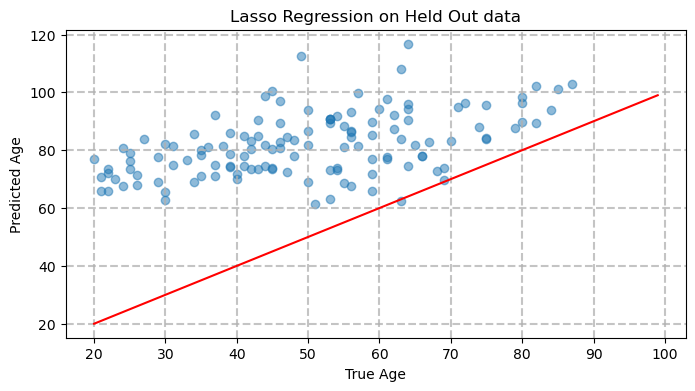

The MSE on the saved data is 1238.266 years
The rms on the saved data is 35.189 years
The r^2 on the saved data is -3.528
The mae on the saved data is 32.048 years
The correlation on the held out data true-predicted is 0.500


In [68]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_lasso_100_brain, mtype='Lasso Regression', figsize=(8,4), xlim=None)




In [72]:
count = 0
brain_breast_blood = []
for cpg in cpgs_XGboost_brain_ranked[:100]:
    if cpg in cpgs_XGboost_breast_ranked[:100]:
        if cpg in cpgs_XGboost_whole_blood_ranked[:100]:
            brain_breast_blood.append(cpg)
            print(cpg)
            count+=1
print(count)

cg24079702
cg23606718
2


In [82]:
list(cpgs_XGboost_whole_blood_ranked).index('cg23606718')

18

In [83]:
list(cpgs_XGboost_brain_ranked).index('cg23606718')

52

In [84]:
list(cpgs_XGboost_breast_ranked).index('cg23606718')

0

In [85]:
list(cpgs_XGboost_whole_blood_ranked).index('cg24079702')

51

In [86]:
list(cpgs_XGboost_brain_ranked).index('cg24079702')

43

In [87]:
list(cpgs_XGboost_breast_ranked).index('cg24079702')

96